[<img src="https://user-images.githubusercontent.com/79705081/109483674-d3eea600-7a7f-11eb-9a25-58c50da4cde9.png">](http://edenlibrary.ai/)

## Instructions
To run any of Eden's notebooks, please check the guides on our [Wiki page](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki).<br>
There you will find instructions on how to deploy the notebooks on [your local system](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-Locally), on [Google Colab](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-GColab), or on [MyBinder](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-MyBinder), as well as other useful links, troubleshooting tips, and more.<br>
For this notebook you will need to download the **Cotton-100619-Healthy-zz-V1-20210225102300**, **Black nightsade-220519-Weed-zz-V1-20210225102034**, **Tomato-240519-Healthy-zz-V1-20210225103740** and **Velvet leaf-220519-Weed-zz-V1-20210225104123** datasets from [Eden Library](https://edenlibrary.ai/datasets), and you may want to use the **eden_tensorflow_transfer_learning.yml** file to recreate a suitable conda environment.

**Note:** If you find any issues while executing the notebook, don't hesitate to open an issue on Github. We will try to reply as soon as possible.

## Background

**Disclaimer**: This notebook was highly inspired by François Chollet's work in https://keras.io/examples/vision/grad_cam/ . Do not hesitate to visit his amazing tutorial!!

In this notebook, we are going to cover a technique called **Grad-CAM** (besides **Transfer Learning**). Grad-CAM (https://arxiv.org/abs/1610.02391), aims to improve the shortcomings of its predecessor (CAM) and, thus, provide a clear class discriminative saliency maps for demystifying the complexity behind the denominated black-box models. The output of Grad-CAM is a heatmap visualization for a given class label (either the top predicted label or an arbitrary label we may select for debugging). We can use this heatmap to visually verify where the CNN is paying attention inside the image. The technique does not require any modifications to the analyzed model architecture and, therefore, this allows to **apply to any CNN-based architecture**. Grad-Cam uses the **gradient information flowing into the last convolutional layer** of the CNN to understand its pattern modelling. New developments have arisen in the last years: for instance, its output can be improved further by combining **guided backpropagation**.

In **agriculture**, since **weeds** compete with crops in the domain of space, light and nutrients, they are an important problem that can lead to a poorer harvest by farmers. To avoid this, weeds should be removed at every step of the growth, but especially at the initial stages. For that reason, identifying weeds accurately by deep learning has arisen as an important objective. Related to this, we can find the disease detection problem, where transfer learning has also been used. Among the most relevant recent works, we can find:

**Wang et al., (2017)** used transfer learning in order to obtain the best neural-based method for disease detection in plants. They extended the apple black rot images in the PlantVillage dataset, which were further annotated by botanists with four severity stages as ground truth. Then, they evaluated the performances of shallow networks trained from scratch and deep models fine-tuned by transfer learning. Their best model was the **VGG16** architecture trained with transfer learning, which yielded an overall accuracy of 90.4% on the hold-out test set. In **Mehdipour-Ghazi et al., (2017)**, the authors used the plant datasets of LifeCLEF 2015. Three popular deep learning architectures were evaluated: **GoogLeNet, AlexNet, and VGGNet**.  Their best combined system (a combination of GoogleNet and VGGNet) achieved an overall accuracy of 80% on the validation set and an overall inverse rank score of 0.752 on the official test set. In **Suh et al., (2018)**, the authors compared different transfer learning approaches in order to find a suitable approach for weed detection (volunteer potato). Their highest classification accuracy for **AlexNet** was 98.0%. Comparing different networks, their highest classification accuracy  was 98.7%, which was obtained with **VGG-19**. Additionally, all scenarios and pre-trained networks were feasible for real-time applications (classification time < 0.1 s). Another relevant study has been performed by **Kounalakis et al., (2019)** where they evaluated transfer learning by a combination of CNN-based feature extraction and linear classifiers to recognize rumex under real-world conditions. Their best system (**Inception_v1**+L2regLogReg) achieved an accuracy of 96.13 with a false positive rate of 3.62. In **Too et al., (2019)**, the authors used transfer learning achieving a performance of 99.75% with the **DenseNet** architecture. Finally, in **Espejo-Garcia et al., (2020)**, authors used transfer learning using agricultural datasets for pre-training neural networks, and afterwards, they fine-tuned the networks for classifying 4 species extracted from the **Eden Platform**. Their maximum performance was 99.54% by using the **Xception** architecture.

This notebook represents an extension over the previous Eden notebooks:
1. https://github.com/Eden-Library-AI/eden_library_notebooks/blob/master/image_classification/weeds_identification-transfer_learning-1.ipynb
2. https://github.com/Eden-Library-AI/eden_library_notebooks/blob/master/image_classification/weeds_identification-transfer_learning-2.ipynb
3. https://github.com/Eden-Library-AI/eden_library_notebooks/blob/master/image_classification/weeds_identification-transfer_learning-3.ipynb
4. https://github.com/Eden-Library-AI/eden_library_notebooks/blob/master/image_classification/weeds_identification-transfer_learning-4.ipynb
5. https://github.com/Eden-Library-AI/eden_library_notebooks/blob/master/image_classification/weeds_identification-transfer_learning-5.ipynb
6. https://github.com/Eden-Library-AI/eden_library_notebooks/blob/master/image_classification/weeds_identification-transfer_learning-6.ipynb
7. https://github.com/Eden-Library-AI/eden_library_notebooks/blob/master/image_classification/weeds_identification-transfer_learning-7.ipynb

## Notebook Structure
This notebook is divided into two parts:
1. Transfer Learning with EfficientNetB0 + Data Augmentation
2. Model Interpretability with Grad-CAM

### 1. Transfer Learning with EfficientNetB0 + Data Augmentation 

#### Library Imports

In [14]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob
from pathlib import Path

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import *
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import Callback
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split

import matplotlib.cm as cm
from numpy import expand_dims

#### Auxiliar functions

In [15]:
class EnoughPerformanceReached(Callback):
    """
    Callback for stopping training when the performance is greater than <threshold>.
    """

    def __init__(self, threshold):
        self.monitor = "val_categorical_accuracy"
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs):
        current_accuracy = logs.get(self.monitor)
        if current_accuracy >= self.threshold:
            print(f"[INFO] Enough performance reached: {current_accuracy}")
            self.model.stop_training = True


# Function for plotting images.
def plot_sample(X):
    """
    Given the array of images <X>, it plots a random subsample of 25 images.

        Parameters:
            X (ndarray): The array with all the images.
    """
    # Plotting 25 sample images
    nb_rows = 5
    nb_cols = 5
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(6, 6))

    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].axis("off")
            axs[i, j].imshow(X[random.randint(0, X.shape[0] - 1)])

    plt.show()


def read_data(path_list, im_size=(224, 224)):
    """
    Given the list of paths where the images are stored <path_list>,
    and the size for image decimation <im_size>, it returns 2 Numpy Arrays
    with the images and labels; and a dictionary with the mapping between
    classes and folders. This will be used later for displaying the predicted
    labels.

        Parameters:
            path_list (List[String]): The list of paths to the images.
            im_size (Tuple): The height and width values.

        Returns:
            X (ndarray): Images
            y (ndarray): Labels
            tag2idx (dict): Map between labels and folders.
    """

    X = []
    y = []

    # Exctract the file-names of the datasets we read and create a label dictionary.
    tag2idx = {tag.split(os.path.sep)[-1]: i for i, tag in enumerate(path_list)}

    for path in path_list:
        for im_file in tqdm(glob(path + "*/*")):  # Read all files in path
            try:
                # os.path.separator is OS agnostic (either '/' or '\'),[-2] to grab folder name.
                label = im_file.split(os.path.sep)[-2]
                im = cv2.imread(im_file, cv2.IMREAD_COLOR)
                # By default OpenCV read with BGR format, return back to RGB.
                im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
                # Resize to appropriate dimensions.You can try different interpolation methods.
                im = cv2.resize(im, im_size, interpolation=cv2.INTER_AREA)
                X.append(im)
                y.append(tag2idx[label])  # Append the label name to y
            except Exception as e:
                # In case annotations or metadata are found
                print("Not a picture")

    X = np.array(X)  # Convert list to numpy array.
    y = np.eye(len(np.unique(y)))[y].astype(np.uint8)
    idx2tag = {v: k for k, v in tag2idx.items()}

    return X, y, idx2tag


# Callbacks are used for saving the best weights and
# early stopping.
def get_callbacks(weights_file, patience, lr_factor):
    """
    Callbacks are used for saving the best weights and early stopping.
    Given some configuration parameters, it creates the callbacks that
    will be used by Keras after each epoch.

        Parameters:
            weights_file (String): File name for saving the best model weights.
            patience (Integer): Number of epochs without improvement to wait.
            lr_factor: Factor for reducing the learning rate when performance
                       is not improving.

        Returns:
            callbacks (List[Callbacks]): Configured callbacks ready to use.
    """
    return [
        # Only save the weights that correspond to the maximum validation accuracy.
        ModelCheckpoint(
            filepath=weights_file,
            monitor="val_categorical_accuracy",
            mode="max",
            save_best_only=True,
            save_weights_only=True,
        ),
        # If val_loss doesn't improve for a number of epochs set with 'patience' var
        # training will stop to avoid overfitting.
        EarlyStopping(
            monitor="val_categorical_accuracy", mode="max", patience=patience, verbose=1
        ),
        EnoughPerformanceReached(0.99),
        # Learning rate is reduced by 'lr_factor' if val_loss stagnates
        # for a number of epochs set with 'patience' var.
        ReduceLROnPlateau(
            monitor="val_loss",
            mode="min",
            factor=lr_factor,
            min_lr=1e-6,
            patience=patience // 2,
            verbose=1,
        ),
    ]

#### Experimental Constants and Paths to the images
**Warning**: Check whether your paths coincide with the coded ones in the cell below.

In [16]:
INPUT_SHAPE = (224, 224, 3)
IM_SIZE = (224, 224)
NUM_CLASSES = 4
NUM_EPOCHS = 20
BATCH_SIZE = 4
TEST_SPLIT = 0.15
VAL_SPLIT = 0.15
BASE_LEARNING_RATE = 1e-4
RANDOM_STATE = 2021
HIDDEN_UNITS = 128
WEIGHTS_FILE_NAME = "weights.h5"  # File that stores updated weights
VERBOSE_LEVEL = 1
AUTO = tf.data.AUTOTUNE
BASE_PATH = ".." + os.path.sep + "eden_library_datasets" + os.path.sep

# Datasets' paths we want to work on.
PATH_LIST = [
    BASE_PATH + "Cotton-100619-Healthy-zz-V1-20210225102300",
    BASE_PATH + "Black nightsade-220519-Weed-zz-V1-20210225102034",
    BASE_PATH + "Tomato-240519-Healthy-zz-V1-202102251037402",
    BASE_PATH + "Velvet leaf-220519-Weed-zz-V1-20210225104123",
]

#### Loading images

In [17]:
x, y, idx2tag = read_data(PATH_LIST, IM_SIZE)

 60%|██████    | 75/124 [00:15<00:10,  4.84it/s]

Not a picture


 64%|██████▍   | 130/202 [00:42<00:26,  2.67it/s]

Not a picture


 69%|██████▉   | 84/121 [00:17<00:05,  6.37it/s]

Not a picture


100%|██████████| 121/121 [00:24<00:00,  4.86it/s]


#### Displaying some sample images

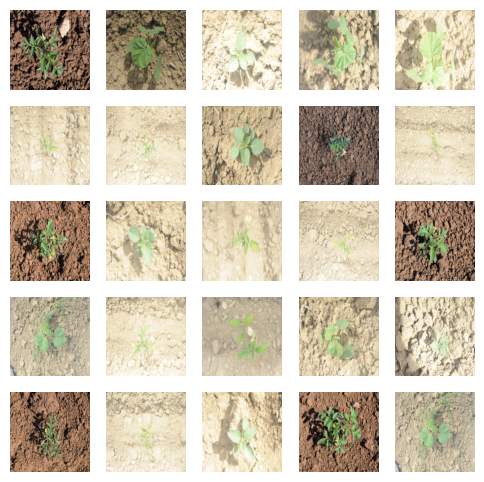

In [18]:
plot_sample(x)

#### Architecture Definition: EfficientNetB0

In [19]:
# Backbone model for feature extraction.
backbone = applications.efficientnet.EfficientNetB0(
          weights="imagenet",
          include_top=False,
          input_shape=INPUT_SHAPE)

# Create new model on top.
features = layers.GlobalAveragePooling2D(name="backbone_pool")(backbone.output) # Flattening layer.
fully = layers.Dense(units=HIDDEN_UNITS, activation="softmax")(features)
outputs = layers.Dense(units=NUM_CLASSES, 
                       activation="softmax",
                       name="predictions")(fully)
# This is the final model.            
model = Model(backbone.input, outputs)

# Compiling model with quite standard parameters
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=BASE_LEARNING_RATE),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

#### Data Splitting

In [20]:
preprocess_input = applications.efficientnet.preprocess_input

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=TEST_SPLIT,
                                                    shuffle = True,
                                                    stratify = y,
                                                    random_state = RANDOM_STATE)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                  test_size=VAL_SPLIT, 
                                                  shuffle = True,
                                                  stratify = y_train,
                                                  random_state = RANDOM_STATE)

#### Data augmentation
We define a couple of data augmentation techniques for avoiding overfitting.

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.02),
  layers.RandomZoom(0.2)                                     
])

#### Transforming Numpy Arrays into TF Datasets
Data augmentation is only used while training

In [22]:
train_ds = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(BATCH_SIZE)
    .map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=AUTO)
    .map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

val_ds = (
    tf.data.Dataset.from_tensor_slices((x_val, y_val))
    .map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

#### Training EfficientNetB0

In [23]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=NUM_EPOCHS,
    callbacks=get_callbacks(
        weights_file=WEIGHTS_FILE_NAME, patience=NUM_EPOCHS // 5, lr_factor=0.8
    ),
    verbose=VERBOSE_LEVEL,
)

Epoch 1/20
89/89 [==============================] - 14s 68ms/step - loss: 1.3623 - categorical_accuracy: 0.4802 - val_loss: 1.3224 - val_categorical_accuracy: 0.6190
Epoch 2/20
89/89 [==============================] - 4s 50ms/step - loss: 1.2888 - categorical_accuracy: 0.7090 - val_loss: 1.2559 - val_categorical_accuracy: 0.7778
Epoch 3/20
89/89 [==============================] - 4s 50ms/step - loss: 1.2440 - categorical_accuracy: 0.7119 - val_loss: 1.2150 - val_categorical_accuracy: 0.8254
Epoch 4/20
89/89 [==============================] - 4s 50ms/step - loss: 1.2238 - categorical_accuracy: 0.8051 - val_loss: 1.1938 - val_categorical_accuracy: 0.9524
Epoch 5/20
89/89 [==============================] - 5s 51ms/step - loss: 1.1986 - categorical_accuracy: 0.8418 - val_loss: 1.1700 - val_categorical_accuracy: 0.9524
Epoch 6/20
89/89 [==============================] - 5s 51ms/step - loss: 1.1707 - categorical_accuracy: 0.8955 - val_loss: 1.1496 - val_categorical_accuracy: 0.9524
Epoch 7/2

#### Evaluating the performance of the model on the test set

In [29]:
_, test_accuracy = model.evaluate(test_ds, batch_size=1, verbose=0)

print(f"Test Accuracy: {round(100*test_accuracy,2)}%")

Test Accuracy: 100.0%


### 2. Model Interpretability with Grad-CAM
**Grad-CAM** provides better localization and clear class discriminative saliency maps which allow demystifying the complexity behind the black-box like models. The output of Grad-CAM is a **heatmap visualization** for a given class label (either the top predicted label or an arbitrary label we select for debugging). We can use this heatmap to visually verify where the CNN is looking at. The technique does not require any modifications to the existing model architecture and this allows us to apply to **any CNN-based architecture**. **Grad-Cam uses the gradient information** flowing into the last convolutional layer of the CNN to understand each neuron for a decision of interest. Its output can be improved further by combining with guided backpropagation.

#### Experimental Constants

In [30]:
# Last Convolutional Layer of EfficientNetB0
LAST_CONV_LAYER_NAME = (
    "top_activation"  # Name of the layer from where the gradients are computed
)

#### Auxiliar functions

In [31]:
def get_img_array(image):
    """
    This function adds a dimension to transform the array into the "batch"
    of size (1, NUM_ROWS, NUM_COLUMNS, NUM_CHANNELS) that Keras needs.
    """
    image = np.expand_dims(image, axis=0)
    return image


def plot_features(image, class_name, true_label, class_channel, heatmap):
    """
    Given the <image> and the <heatmap>, this function displays the
    Grad-CAM output on the image, besides additional information such as
    <class_name>, <true_label> and <class_channel>.
    """
    # Display heatmap
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 3, 1)
    plt.title("Grad-CAM Convolution", fontsize=8)
    plt.imshow(heatmap)
    heatmap = cv2.resize(heatmap, IM_SIZE)
    plt.subplot(1, 3, 2)

    plt.title(
        f"Truth: {true_label} - Predicted: {class_name.split('-')[0]} ({round(100*class_channel[0])}%)",
        fontsize=6,
    )
    plt.imshow(img_array[0].astype(np.uint8))
    plt.axis("off")
    plt.subplot(1, 3, 3)

    plt.title("Heatmap", fontsize=8)
    plt.imshow(img_array[0].astype(np.uint8))
    plt.imshow(heatmap, alpha=0.5)
    plt.axis("off")

    plt.show()


def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    """
    Given the image (<img_array>), the trained <model> and the name of the
    last convolutional layer <last_conv_layer_name>, this functions computes
    the heatmap with the relevance of each feature.
    """
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        pred_index = tf.argmax(preds[0])
        class_name = idx2tag[K.eval(pred_index)]
        # print(preds)
        class_channel = preds[:, pred_index]  # Class-Proba
        # print(class_channel)

    # We compute the gradient of the top predicted output neuron
    # with regard to the output feature map of the last conv layer
    # Intuitively, it tells us how important each channel is with regard
    # to the target class.
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel. The gradients thus obtained are then
    # global average pooled to obtain the neuron important weights corresponding
    # to the target class.
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation.
    # In other words, we multiply each activation map with corresponding pooled gradients
    # which acts as weights determining how important each channel is with regard
    # to the target class.
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purposes, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy(), class_name, K.eval(class_channel)

### Testing Grad-CAM with 4 sample images

In [32]:
test_paths = [
    "../eden_library_datasets/Tomato-240519-Healthy-zz-V1-202102251037402/DSC_0198.JPG",
    "../eden_library_datasets/Cotton-100619-Healthy-zz-V1-20210225102300/DSC_0634.JPG",
    "../eden_library_datasets/Black nightsade-220519-Weed-zz-V1-20210225102034/DSC_0500.JPG",
    "../eden_library_datasets/Velvet leaf-220519-Weed-zz-V1-20210225104123/DSC_0477.jpg",
]

true_labels = ["Tomato", "Cotton", "Black Nightshade", "Velvet Leaf"]

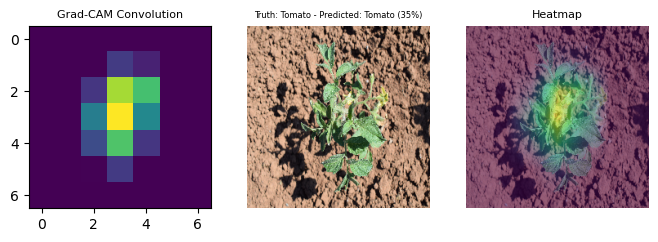

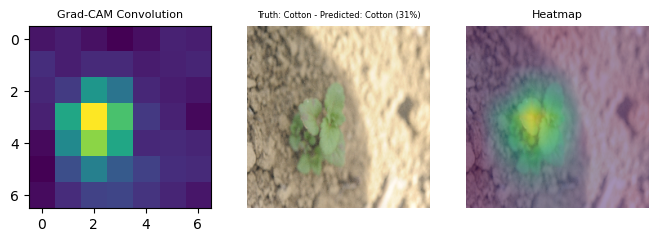

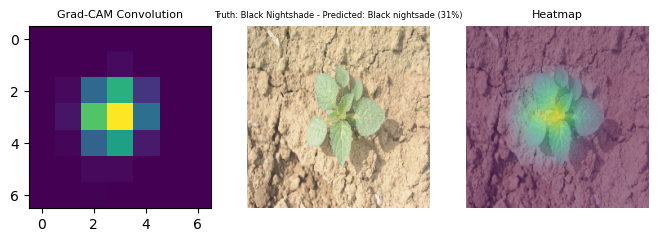

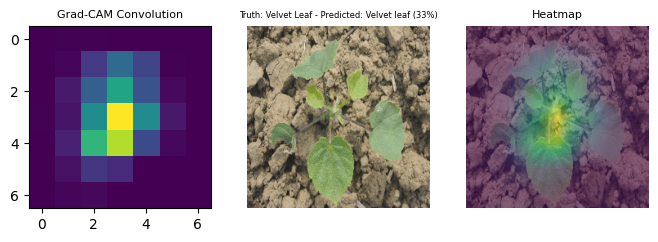

In [33]:
for test_path, true_label in zip(test_paths, true_labels):
    img_array = preprocess_input(
        get_img_array(np.array(load_img(test_path, target_size=INPUT_SHAPE)))
    )

    heatmap, class_name, class_channel = make_gradcam_heatmap(
        img_array, model, LAST_CONV_LAYER_NAME
    )
    plot_features(img_array, class_name, true_label, class_channel, heatmap)

## Possible Extensions
1. Change the number of epochs used while fine-tuning (20 in this notebook).
2. Use other dataset from the <a href="https://edenlibrary.ai">Eden platform</a>.
3. Change the learning rate used while fine-tuning (1e-4 in this notebook).

## Bibliography
Bengio, Y., 2012. Deep Learning of Representations for Unsupervised and Transfer Learning. In: Journal of Machine Learning Research; 17–37.

Espejo-Garcia, B., Mylonas, N., Athanasakos, L., & Fountas, S., (2020). Improving
Weeds Identification with a Repository of Agricultural Pre-trained Deep Neural
Networks. Computers and Electronics in Agriculture; 175 (August).

Howard, A.G., Sandler, M., Chu, G., Chen, L., Chen, B., Tan, M., Wang, W., Zhu, Y., Pang, R., Vasudevan, V., Le, Q.V., & Adam, H. (2019). Searching for MobileNetV3. 2019 IEEE/CVF International Conference on Computer Vision (ICCV), 1314-1324.

Kounalakis T., Triantafyllidis G. A., Nalpantidis L., (2019). Deep learning-based visual recognition of rumex for robotic precision farming. Computers and Electronics in Agriculture.

Mehdipour-Ghazi, M., Yanikoglu, B.A., & Aptoula, E. (2017). Plant identification using deep neural networks via optimization of transfer learning parameters. Neurocomputing, 235, 228-235.

Sandler, M., Howard, A.G., Zhu, M., Zhmoginov, A., & Chen, L. (2018). MobileNetV2: Inverted Residuals and Linear Bottlenecks. 2018 IEEE/CVF Conference on Computer Vision and Pattern Recognition, 4510-4520.

Selvaraju, R.R., Das, A., Vedantam, R., Cogswell, M., Parikh, D., & Batra, D. (2019). Grad-CAM: Visual Explanations from Deep Networks via Gradient-Based Localization. International Journal of Computer Vision, 128, 336-359.

Suh, H.K., IJsselmuiden, J., Hofstee, J.W., van Henten, E.J., (2018). Transfer learning for the classification of sugar beet and volunteer potato under field conditions. Biosystems Engineering; 174:50–65.

Too, E.C., Yujian, L., Njuki, S., & Ying-chun, L. (2019). A comparative study of fine-tuning deep learning models for plant disease identification. Comput. Electron. Agric., 161, 272-279.

Wang, G., Sun, Y., Wang, J., (2017). Automatic Image-Based Plant Disease Severity Estimation Using Deep Learning. Computational Intelligence and Neuroscience; 2017:8.




https://mrsalehi.medium.com/a-review-of-different-interpretation-methods-in-deep-learning-part-1-saliency-map-cam-grad-cam-3a34476bc24d

https://keras.io/examples/vision/grad_cam/

## Acknowledgements
This notebook was highly inspired by the work of **François Chollet** (https://keras.io/examples/vision/grad_cam/)